<a href="https://colab.research.google.com/github/francisco-ar/ml_diagnosis_pv/blob/main/Failure_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import data

In [ ]:
!git clone https://github.com/francisco-ar/ml_diagnosis_pv

Cloning into 'ml_diagnosis_pv'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 2), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [ ]:
!ls ml_diagnosis_pv/

faultypv_res_rp_variation.hdf  faultypv_res_rs_variation.hdf
faultypv_res_rp_variation.npy  faultypv_res_rs_variation.npy


In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_rs = np.load("ml_diagnosis_pv/faultypv_res_rs_variation.npy")
data_rp = np.load("ml_diagnosis_pv/faultypv_res_rp_variation.npy")

In [ ]:
data_rs.shape, data_rp.shape, data_rs.dtype, data_rp.dtype

((60, 2, 202), (48, 2, 202), dtype('float64'), dtype('float64'))

Plot a couple of courbes:

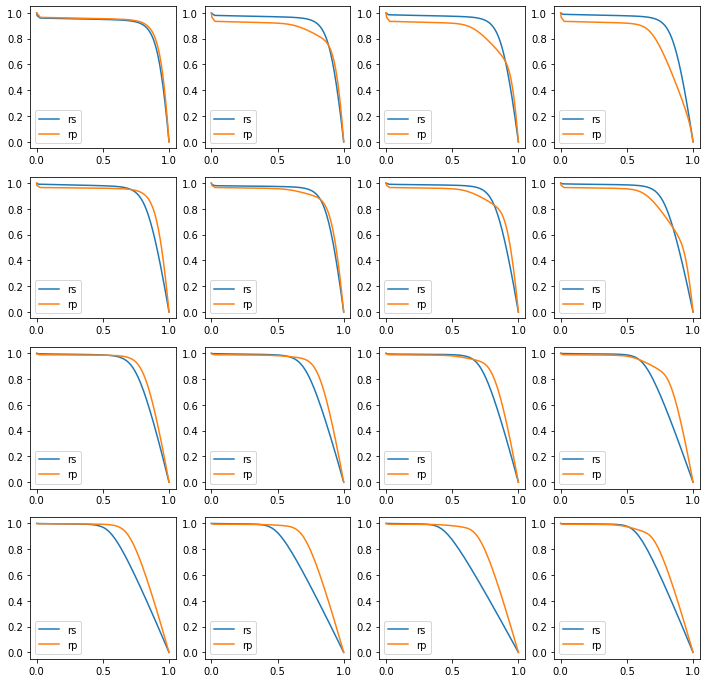

In [ ]:
idx = np.random.randint(0,20)
ex_rs = data_rs[idx]
ex_rp = data_rp[idx]

def plot_one(ex_rs, ex_rp, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.plot(ex_rs[0], ex_rs[1], label="rs")
    ax.plot(ex_rp[0], ex_rp[1], label="rp")
    ax.legend(loc="best")

n = 4

for ax, ex_rs, ex_rp in zip(plt.subplots(n, n, figsize=(n*3, n*3))[1].flatten(), data_rs, data_rp):
    plot_one(ex_rs, ex_rp, ax=ax)

Prepare data

In [ ]:
y = np.concatenate([np.zeros(len(data_rs)), np.ones(len(data_rp))])
y = y[:, None] # add trailing dim
y.shape

(108, 1)

In [ ]:
X = np.concatenate([data_rs, data_rp])
X = X.transpose(0,2,1)
X = X[:, :199, :]
X.shape

(108, 199, 2)

# TODO: Echarse los nans.

In [ ]:
X[np.isnan(X)]=0. # nos es buena idea

We have to shuffle the data

In [ ]:
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

A Simple model

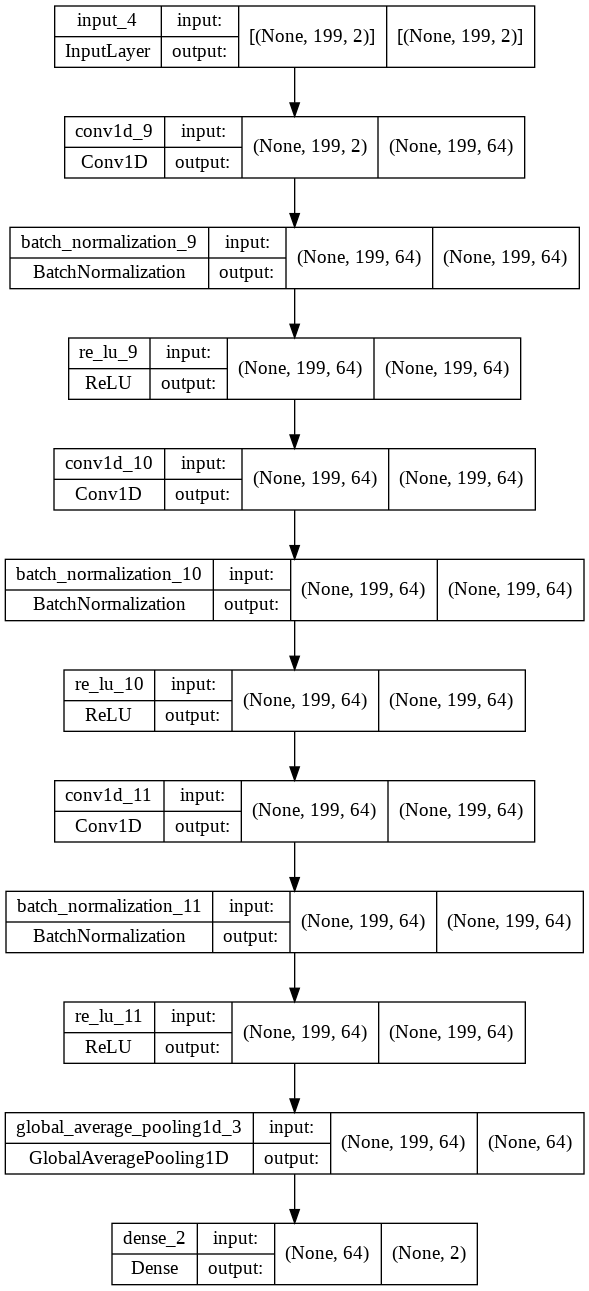

In [ ]:
num_classes = 2

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 16

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
6/6 [==============================] - 2s 91ms/step - loss: 0.6974 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.4091 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 40ms/step - loss: 0.6693 - sparse_categorical_accuracy: 0.5930 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.3182 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 37ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.6047 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.3636 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 39ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.3182 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 37ms/step - loss: 0.6621 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.3636 - lr: 0.0010
Epoch 6/100
6/6 [============================